In [1]:
# Load in packages
import numpy as np
import matplotlib as plt 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import scipy.special as sc
import pandas as pd
import scipy.stats as stats
from pprint import pprint

In [3]:
# Problem 1 a)
# Using the forward algorithm to predict the most likely sequence state (latent)
# given the data in 'cgh.csv' log_ratio

observations = pd.read_csv('cgh.csv', header=None).values.flatten()
log_ratio = [observations[i] for i in range(len(observations)) if i % 2 != 0]

# Model parameters
states = ['deleted', 'normal', 'duplicated']
transition_probabilities = np.array([[0.50, 0.50, 0.00],
                                     [0.05, 0.90, 0.05],
                                     [0.00, 0.50, 0.50]])
emission_means = np.array([-1, 0, 1])
emission_stddevs = np.array([0.7, 0.5, 0.7])
initial_probabilities = np.array([0, 1, 0])  

num_states = len(states)
num_observations = len(log_ratio)

# Convert transition probabilities to log-space
# Initialize the forward and transition matrix with a small number for log(0)
epsilon = 1e-10
transition_probabilities_eps = np.clip(transition_probabilities, epsilon, 1)
log_transition_probabilities = np.log(transition_probabilities_eps)
log_forward_matrix = np.full((num_observations, num_states), epsilon)

# Start in the normal state
log_forward_matrix[0,] = initial_probabilities * (-0.5 * (np.log(2 * np.pi * (emission_stddevs[1] ** 2)) + \
                           ((log_ratio[0] - emission_means[1]) / emission_stddevs[1]) ** 2))

for t in range(1, num_observations):
    for s in range(num_states):
        log_emission_prob = -0.5 *( np.log(2 * np.pi * (emission_stddevs[s] ** 2)) + \
                             ((log_ratio[t] - emission_means[s]) / emission_stddevs[s]) ** 2)
        log_probs = log_forward_matrix[t - 1, :] + log_transition_probabilities[:, s]
        log_forward_matrix[t, s] = sc.logsumexp(log_probs) + log_emission_prob

# Compute the log probability of the sequence
log_P_Y = sc.logsumexp(log_forward_matrix[-1, :])
print('log_P_Y =', log_P_Y)

log_P_Y = -195.37119458534062


In [4]:
# Problem 1 b)

# Use the Viterbi algorithm to find the MAP estimate for X. 

def viterbi_algorithm(log_ratio, log_transition_probabilities, emission_means, emission_stddevs):
    num_states = log_transition_probabilities.shape[0]
    num_observations = len(log_ratio)

    log_probs = np.full((num_states, num_observations), -np.inf)
    paths = np.zeros((num_states, num_observations), dtype=int)

    # Initialization step
    for s in range(num_states):
        if s == 1:  
            log_probs[s, 0] = (-0.5 * (np.log(2 * np.pi * (emission_stddevs[s] ** 2)) + \
                           ((log_ratio[0] - emission_means[s]) / emission_stddevs[s]) ** 2))
        else:
            log_probs[s, 0] = np.log(1e-10)

    # Recursion step
    for t in range(1, num_observations):
        for s in range(num_states):
            # Calculate log prob. of paths to state s
            log_trans_probs = log_probs[:, t-1] + log_transition_probabilities[:, s]
            # Calculate emission probability
            log_emission_prob = (-0.5 * (np.log(2 * np.pi * (emission_stddevs[s] ** 2)) + \
                           ((log_ratio[t] - emission_means[s]) / emission_stddevs[s]) ** 2))
            # Find maximum prob
            log_probs[s, t] = np.max(log_trans_probs) + log_emission_prob
            paths[s, t] = np.argmax(log_trans_probs)

    # Find the state with the maximum probability
    last_X = np.argmax(log_probs[:, num_observations-1])
    max_log_prob = log_probs[last_X, num_observations-1]

    # Build path by backtracking
    optimal_path = np.zeros(num_observations, dtype=int)
    optimal_path[-1] = last_X
    for t in range(num_observations-2, -1, -1):
        optimal_path[t] = paths[optimal_path[t+1], t+1]

    return optimal_path, max_log_prob

viterbi_path, log_p_viterbi_path = viterbi_algorithm(log_ratio, log_transition_probabilities, emission_means, emission_stddevs)

# Index in description starts at 1
X_hat = viterbi_path + 1
print('X_hat =', X_hat)
print('mode(X_hat) =', stats.mode(viterbi_path+1))
print('log P(X_hat | Y) =', log_p_viterbi_path)

X_hat = [2 2 2 2 2 2 2 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3
 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
mode(X_hat) = ModeResult(mode=2, count=158)
log P(X_hat | Y) = -212.9374886468753


C:\Users\dkell\AppData\Local\Temp\ipykernel_6052\2857632825.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(mapped_means, 'r-', label='Emission Means (Viterbi Path)', linewidth=2, color= 'grey')


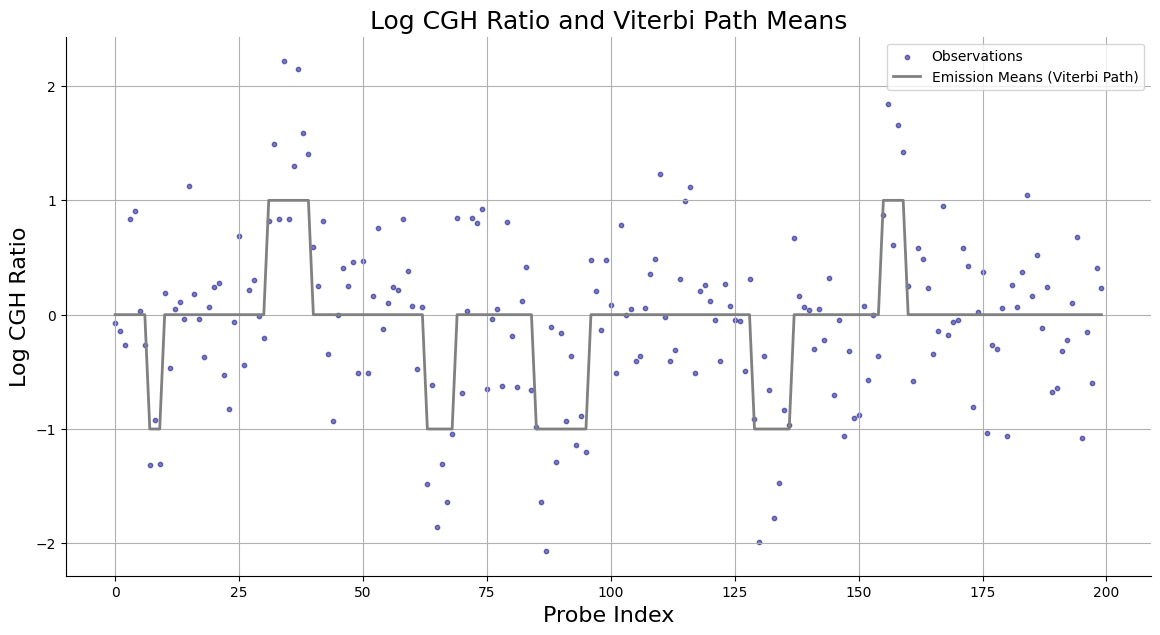

In [5]:
# Problem 1 c)

# Plot the log_ratio Y and for each probe i, the corresponding mean, mu, 
# of the MAP estimate hat_X_i

mapped_means = emission_means[viterbi_path]
plt.figure(figsize=(14, 7))
plt.scatter(np.arange(len(log_ratio)), log_ratio, label='Observations', alpha=0.5, s=10, color = 'navy')
plt.plot(mapped_means, 'r-', label='Emission Means (Viterbi Path)', linewidth=2, color= 'grey')
plt.title('Log CGH Ratio and Viterbi Path Means', fontsize = 18)
plt.xlabel('Probe Index', fontsize=16)
plt.ylabel('Log CGH Ratio', fontsize = 16)
plt.legend()
sns.despine()
plt.grid(True)
plt.show()

1 c) The plot here shows that $\hat{X}$ is a reasonable fit given the data $Y$, but with room for improvement. For example, our observations closely match the Viterbi path for our probe indices less than 45. Then, around probe index 50 we start to estimate that the state is normal when the observations appear to stray towards the duplicated state, a log ratio near 1. There are other deviations, for example in the range beyond 150, where we observe duplicated and deleted states even though the Viterbi Path indicates they are more likely to be normal.  

In [6]:
# Probability lasy probe is truly 'normal' given Y, the log ratios
# -> P(last is normal | Y) / sum_{last iterates} P(forward)
P_normal_last_probe = np.exp(log_forward_matrix[-1, 1]) / np.sum(np.exp(log_forward_matrix[-1, :]))
print('P(last is normal) =', P_normal_last_probe)

# Ratio of probabilities for 'deleted' over 'duplicated' for the last probe
P_deleted_last_probe = np.exp(log_forward_matrix[-1, 0])
P_duplicated_last_probe = np.exp(log_forward_matrix[-1, 2])

# How much more likely is 'deleted' than 'duplicated'
likelihood_ratio = P_deleted_last_probe / P_duplicated_last_probe
print('likelihood_ratio: P(deleted)/P(duplicated) =', likelihood_ratio)

P(last is normal) = 0.9586746595772814
likelihood_ratio: P(deleted)/P(duplicated) = 0.32166331646788093


1 d) Given the observed CGH ratios, the probability the last probe is normal is approximately $0.96.$ Given the observed CGH ratios, the last probe is approximately $32.17\%$ more likely to be deleted than it is to be duplicated. 

In [7]:
# Problem 2 a) 

# Forward algorithm for the log normalizing constant log Z_x. 

# The forward algorithm for a provided visitation order
def forward_algorithm(visitation_order, neighbors):
    messages = {node: np.ones(2) for node in visitation_order}
    def calculate_message(current, messages, neighbors):
        message = np.zeros(2)
        for state in [0, 1]:
            product = 1 
            for neighbor in neighbors[current]:
                product *= sum(np.exp(2 * abs(state - np.array([0, 1])) - 1) * messages[neighbor])
            message[state] = product
        return message
    
    # Iterate over the visitation order and compute the messages
    for node in visitation_order:
        messages[node] = calculate_message(node, messages, neighbors)
        
    Zx = sum(messages[visitation_order[-1]])
    return Zx

# Define the visitation order and the neighbors for each node
visitation_order = [9, 6, 8, 7, 4, 1, 3, 2, 5]
neighbors = {
    1: [2],
    2: [1, 3, 5],
    3: [2],
    4: [5, 7, 8],
    5: [2, 4, 6],
    6: [5, 9],
    7: [4, 8],
    8: [7],
    9: [6]
}

Zx = forward_algorithm(visitation_order, neighbors)
log_Zx = np.log(Zx)
print('log Z_x =', log_Zx)

log Z_x = 20.977851379333448


In [10]:
#Problem 2 b)

# Configuration
Y = np.array([2, 2, 2, 2, 0, 0, 1, 2, 1])
mu = np.array([2, 0.5]) 
sigma_1 = 1  
sigma_2 = 0.5
sigma = np.array([sigma_1, sigma_2])

# The local likelihood function for a node given the state
def local_likelihood(Y_i, X_i, mu, sigma_1, sigma_2):
    sigma = sigma_1 if X_i == 0 else sigma_2
    return -0.5 * np.log(2 * np.pi * sigma**2) - ((Y_i - mu[X_i])**2) / (2 * sigma**2)

# Find the likelihood for a given node
def calculate_log_likelihood(node, log_messages, neighbors, Y, mu, sigma_1, sigma_2):
    local_log_likelihoods = np.array([local_likelihood(Y[node-1], state, mu, sigma_1, sigma_2) for state in [0, 1]])
    
    if not neighbors[node]:
        return local_log_likelihoods
    
    # Otherwise, calculate the message considering the states of its neighbors
    log_message = np.full(2, np.log(1e-10))  
    for state in [0, 1]:
        neighbor_log_sums = []
        for neighbor in neighbors[node]:
            neighbor_log_messages = log_messages[neighbor]
            neighbor_weights = np.array([2 * abs(state - neighbor_state) - 1 for neighbor_state in [0, 1]])
            neighbor_log_sums.append(sc.logsumexp(neighbor_log_messages + neighbor_weights))
        log_message[state] = sc.logsumexp(np.array(neighbor_log_sums)) + local_log_likelihoods[state]
    return log_message

log_messages = {node: np.full(2, -np.inf) for node in visitation_order}  # Start with log(0) for all messages
log_messages[9] = np.array([local_likelihood(Y[8], state, mu, sigma_1, sigma_2) for state in [0, 1]])  # Base case for node 9

# Find log messages by the visitation order
for node in visitation_order[1:]:  
    log_messages[node] = calculate_log_likelihood(node, log_messages, neighbors, Y, mu, sigma_1, sigma_2)

final_log_message = sc.logsumexp(log_messages[visitation_order[-1]])

log_P_Y = final_log_message - log_Zx
print('log_P_Y =', log_P_Y)

log_P_Y = -22.436160606080527


In [11]:
# Problem 2 c)
def compute_MAP(Y, visitation_order, neighbors, mu, sigma_1, sigma_2):
    probabilities = {node: np.zeros(2) for node in visitation_order}
    predecessors = {node: [0, 0] for node in visitation_order}
    
    for node in visitation_order:
        for state in [0, 1]:
            local_prob = local_likelihood(Y[node-1], state, mu, sigma_1, sigma_2)
            if node == visitation_order[0]:
                probabilities[node][state] = local_prob
            else:
                max_prob = float('-inf')
                max_prev_state = 0
                for prev_state in [0, 1]:
                    # The max probability and state from previous node's perspective
                    neighbor_max_prob = float('-inf')
                    for neighbor in neighbors[node]:
                        prob_from_prev = probabilities[neighbor][prev_state] + np.log(np.exp(2 * abs(state - prev_state) - 1))
                        if prob_from_prev > neighbor_max_prob:
                            neighbor_max_prob = prob_from_prev
                    # Compare with overall max probability for current state
                    if neighbor_max_prob > max_prob:
                        max_prob = neighbor_max_prob
                        max_prev_state = prev_state
                probabilities[node][state] = max_prob + local_prob
                predecessors[node][state] = max_prev_state
    
    # Backtrace to find the MAP estimate
    MAP_estimate = np.zeros(len(Y), dtype=int)
    last_node = visitation_order[-1]
    last_state = np.argmax(probabilities[last_node])
    MAP_estimate[last_node-1] = last_state

    for node in reversed(visitation_order[:-1]):
        last_state = predecessors[node][last_state]
        MAP_estimate[node-1] = last_state

    # log probability of the MAP estimate given Y
    log_P_MAP_given_Y = np.sum([probabilities[node][MAP_estimate[node-1]] for node in visitation_order])
    P_MAP_given_Y = np.exp(log_P_MAP_given_Y)

    return MAP_estimate, P_MAP_given_Y, log_P_MAP_given_Y


MAP_estimate, P_MAP_given_Y, log_P_MAP_given_Y = compute_MAP(Y, visitation_order, neighbors, mu, sigma_1, sigma_2)
P_MAP_given_Y_normalized = np.exp(log_P_MAP_given_Y - log_Zx)
print('hat_X =', MAP_estimate)
print('P_hatX_given_Y =', P_MAP_given_Y)
print('log_P_MAP_given_Y =', log_P_MAP_given_Y)
print('P_MAP_given_Y_normalized =', P_MAP_given_Y_normalized)


hat_X = [0 0 1 1 1 0 0 1 0]
P_hatX_given_Y = 8.479323088067295e-07
log_P_MAP_given_Y = -13.98046502886102
P_MAP_given_Y_normalized = 6.573491221463011e-16


2 c) From our maximum a posteriori (MAP) estimate $\hat{X},$ we find that pixels (states) $3,4,5,$ and $8$ are estimated to be water. The probability of our MAP estimate given the observed vegetation indices is
$$\mathbb{P}(\hat{X}|Y) \approx 6.57\times10^{\text{-}16}.$$

In [12]:
# Problem 2 d)

# The local likelihood function for a node given the state
def local_likelihood(Y_i, X_i, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma[X_i]**2) - ((Y_i - mu[X_i])**2) / (2 * sigma[X_i]**2)

# Redefine for d) 
def forward_algorithm(visitation_order, neighbors, Y, mu, sigma):
    messages = {node: np.ones(2) for node in visitation_order}
    
    def calculate_message(current, messages, neighbors):
        message = np.zeros(2)
        for state in [0, 1]:
            product = np.exp(local_likelihood(Y[current-1], state, mu, sigma))
            for neighbor in neighbors[current]:
                if visitation_order.index(neighbor) < visitation_order.index(current):
                    product *= sum(np.exp(2 * abs(state - np.array([0, 1])) - 1) * messages[neighbor])
            message[state] = product
        return message
    
    for node in visitation_order:
        messages[node] = calculate_message(node, messages, neighbors)
        
    Zx = sum(messages[visitation_order[-1]])
    return messages, np.log(Zx)

# Backward algorithm
def backward_algorithm(visitation_order, neighbors, Y, mu, sigma):
    messages = {node: np.ones(2) for node in visitation_order}

    def calculate_message(current, messages, neighbors):
        message = np.zeros(2)
        for state in [0, 1]:
            product = np.exp(local_likelihood(Y[current-1], state, mu, sigma))
            for neighbor in neighbors[current]:
                if visitation_order.index(neighbor) > visitation_order.index(current):
                    product *= sum(np.exp(2 * abs(state - np.array([0, 1])) - 1) * messages[neighbor])
            message[state] = product
        return message

    # Backtrace
    for node in reversed(visitation_order):
        messages[node] = calculate_message(node, messages, neighbors)

    return messages

forward_messages, log_Zx = forward_algorithm(visitation_order, neighbors, Y, mu, sigma)
backward_messages = backward_algorithm(visitation_order, neighbors, Y, mu, sigma)

# Compute the marginal probabilities.
def compute_marginal(node, forward_messages, backward_messages, log_Zx):
    marginal = forward_messages[node] * backward_messages[node]
    marginal /= np.exp(log_Zx)  
    return marginal

# Marginal for pixel 5
pixel_5_marginal = compute_marginal(5, forward_messages, backward_messages, log_Zx)
pixel_5_marginal

# Normalize the marginal probabilities for pixel 5
pixel_5_marginal_normalized = pixel_5_marginal / np.sum(pixel_5_marginal)
print('P(X_5 = Water|Y) =', pixel_5_marginal_normalized[1])
print('P(X_5 = Dry|Y) =', pixel_5_marginal_normalized[0])


P(X_5 = Water|Y) = 0.9940276996312749
P(X_5 = Dry|Y) = 0.005972300368725126


d) The probability that pixel 5 is water given the observed vegatation indices is $0.99$, near $1.$ This is in agreement with $\hat{X}$, as our MAP estimate predicts state 5 to be water. However, the extremely low conditional probability (posterior) $\mathbb{P}(\hat{X}|Y)$ gives us little confidence in our estimate. Ultimately, it is reasonable to conclude that our MAP estimate is accurate despite the low posterior probability, since the high number of possible MAP estimates may interfere with our posterior calculation, in fact deflating it. 